In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [3]:
import numpy as np
import pandas as pd
from plotnine import *
from pulp import COIN_CMD
from wurlitzer import sys_pipes

from UCP.data import UCPData
import UCP.model as original_model
import UCP.output.check_solution as ck
from generic.optimization.dual.algorithms.cutting_plane import *
from generic.optimization.dual.algorithms.subgradient import *
from generic.optimization.dual.combined_algorithm import (
    AlgorithmConfiguration,
    BoundsTracker,
    CombinedAlgorithm,
    KpiCollector,
)
from generic.optimization.dual.combined_algorithm import charts as algo_charts
from generic.optimization.dual.combined_algorithm import extract_kpis, pretty_printer
from generic.optimization.solution_extraction import extract_solution
from generic.series_dict import series_dict_to_array
from UCP.output import charts
from UCP.relaxations.combinatorial_heuristic import combinatorial_heuristic
from UCP.relaxations.local_search_heuristic import local_search
from UCP.relaxations.lagrangian.production_state.relaxation import (
    ProductionStateRelaxation,
)

In [4]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [5]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

## Full optimization with Solver

In [6]:
ucp = original_model.create_model(data)
with sys_pipes():
    ucp.model.solve(solver=COIN_CMD(mip=1, options=["node depth seconds 180"]))

optimal_cost = optimal_value = ucp.model.objective.value()

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - cbc /tmp/c21b7d586ecc43a59dfdcc5ac683ae48-pulp.mps node depth seconds 180 branch printingOptions all solution /tmp/c21b7d586ecc43a59dfdcc5ac683ae48-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1909 COLUMNS
At line 8911 RHS
At line 10816 BOUNDS
At line 11537 ENDATA
Problem MODEL has 1904 rows, 1008 columns and 5033 elements
Coin0008I MODEL read with 0 errors
Option for nodeStrategy changed from fewest to depth
seconds was changed from 1e+100 to 180
Continuous objective value is 137513 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 271 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 146 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 38 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 36 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 34 strengthened rows, 0 s

In [7]:
print(f"Cost: {optimal_cost:15.5g}")

Cost:       1.394e+05


# Optimization with Lagrangian Decomposition

## Setup

In [8]:
relaxation = ProductionStateRelaxation(data)

var_lb, var_ub = tuple(
    series_dict_to_array(**m)
    for m in relaxation.multipliers_range()
)

## Subgradient
### Target tracking for the subgradient

Target tracking means over-estimating the optimal value of the Lagrangian Function (LF), as we are maximizing it, to determine the step-size for the subgradient algorithm.

We adopt the following policy:
* We get an upper bound of the optimal value from the current Primal Solution (PS), via the `bounds_tracker`, which tracks the best bounds for the whole algorithm.
* If the current PS value is close to the current LF value then our multipliers are good, the current PS value provides a good target and we need to make smaller steps.
   * We assume that if the two values differ less than 20%, they're close.
   * if the PS has not been computed yet, its value is set to +infinity.
* Otherwise we take the maximum between:
    * the `fixed_tracker` value, which is the best LF value seen so far (best dual bound) over-estimated by 25%.
    * the `lower_cost_estimate`, which is the minimum possible cost of energy
    
  the rationale is that at the beginning the best LF value can be very low, even lower than  the `lower_cost_estimate`. The latter can thus provide a better upper bound estimate and thus larger step-sizes.

In [9]:
upper_bound = np.nan

lower_cost_estimate = data.loads["value"].sum() * data.thermal_plants["l_cost"].min()

fixed_tracker = FixedTargetTracker(sense=-relaxation.sense, overestimation_factor=0.25)

bounds_tracker = BoundsTracker(sense=relaxation.sense)

def target_tracker(current_lf_value: float) -> float:
    upper_bound = bounds_tracker.best_primal_solution.objective
    if abs(upper_bound - current_lf_value) / abs(current_lf_value + 1e-3) > 0.2:
        fixed_target = fixed_tracker(current_lf_value)
        result = max(fixed_target, lower_cost_estimate)
    else:
        result = upper_bound
    return result

In [10]:
sgd_algorithm_conf  = dict(
            sense=-relaxation.sense,
            var_lb=var_lb,
            var_ub=var_ub,
            step_size_fun=PolyakStepSizeRule(-relaxation.sense, target_tracker),
            deflection_fun=make_CFMDeflection(),
        )

## Cutting Plane

In [11]:
cp_algorithm_config = dict(sense=-relaxation.sense, var_lb=var_lb, var_ub=var_ub)

## Primal Heuristic

The primal heuristic takes a list of primal solutions computed by the combined algorithm and extracts plants' commitments from each.

It then uses the commitments to compute a primal solution for the original problem with the following steps:

1) Combination: uses an LP to compute the optimal _fractional_ combination of the commitments and then select for each plant the (first) commitment with highest fractional value.

2) Local-search: uses the original MIP model and the combined solution at #1 to perform local search. It fixes the plants' state in the combined solution except the periods with highest energy cost (estimated via LP optimization as lagrangian multipliers) and then solves the residual MIP.

In [12]:
def run_heuristic(primal_solutions):
    solver_options = ["ratio", "0.05", "sec", "40", "doh", "node depth"]
    commitments = [ps["s"] for ps in primal_solutions]
    solution = combinatorial_heuristic(
        data,
        commitments,
        combination_options=dict(
            mip=0, options=solver_options
        ),
    )
    solution = local_search(data, solution, options=solver_options)
    print(
        f" => Heuristic:\tTotal cost: {solution['total_production_cost']:15.5g}\t"
        + f"Demand mismatch cost:{solution['demand_mismatch_cost']:15.5g}"
    )
    return relaxation.information_from_primal_solution(solution)

## Initialization

In [13]:
configuration = AlgorithmConfiguration(
    primal_feasibility_tolerance=1e-4,
    subgradient_tolerance=1e-6,
    sgd_iterations=4,
    cp_iterations=1,
    heuristic_frequency=6,
    max_gap=0.025,
    max_cp_gap=0.01,
    relaxation_solver_options={},
    cp_solver_options={"options": ["seconds 60"]},
    max_iterations=24,
    sgd_name="Polyak+CFM",
    cp_name="CPM",
)

In [14]:
initial_multipliers = relaxation.fill_multipliers(0.0)

bounds_tracker.reset()
fixed_tracker.reset()

combined_algorithm = CombinedAlgorithm(
    configuration,
    relaxation,
    initial_multipliers,
    cp_algorithm_config,
    sgd_algorithm_conf,
    run_heuristic,
    bounds_tracker=bounds_tracker,
)

## Execution

In [15]:
kpi_collector = KpiCollector()
print(pretty_printer.header() + f"|{'Gap% from Optimum*':>25}")
stop = False
while not stop:
    stop = combined_algorithm()
    kpi_collector.collect(combined_algorithm)
    print(
        pretty_printer.row(kpi_collector)
        + f"|{abs(1- (bounds_tracker.best_primal_solution.objective/optimal_value)):>25.2%}"
    )
    
print("\n* Note: the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.")

| It.|    Dual Algorithm|   Current Dual|    Current Master|      Best Dual|    Best Primal|       Best Master|Optimality Gap%|        CP Gap%|       Gap% from Optimum*
|   0|              None|     1.1202e+05|               inf|     1.1202e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   1|        Polyak+CFM|     1.2217e+05|               inf|     1.2217e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   2|        Polyak+CFM|     1.3052e+05|               inf|     1.3052e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   3|        Polyak+CFM|     1.3138e+05|               inf|     1.3138e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   4|        Polyak+CFM|       1.31e+05|               inf|     1.3138e+05|            inf|               inf|        100.00%|        100.00%|            

Current cost: 1.9e+05. Demand mismatch cost:5.8e+04
New cost: 1.6e+05.New demand mismatch cost:2.7e+04. Improvement: 14.68%


 => Heuristic:	Total cost:      1.6296e+05	Demand mismatch cost:          26737
|   6|        Polyak+CFM|    -7.2561e+05|        9.3958e+05|     1.3138e+05|     1.6296e+05|        9.3958e+05|         19.38%|         86.02%|                   16.90%
|   7|        Polyak+CFM|    -4.1647e+05|        9.3958e+05|     1.3138e+05|     1.6296e+05|        9.3958e+05|         19.38%|         86.02%|                   16.90%
|   8|        Polyak+CFM|    -2.7452e+05|        9.3958e+05|     1.3138e+05|     1.6296e+05|        9.3958e+05|         19.38%|         86.02%|                   16.90%
|   9|        Polyak+CFM|    -1.7538e+05|        9.3958e+05|     1.3138e+05|     1.6296e+05|        9.3958e+05|         19.38%|         86.02%|                   16.90%
|  10|               CPM|    -1.0968e+06|        1.6296e+05|     1.3138e+05|     1.6296e+05|        1.6296e+05|         19.38%|         19.38%|                   16.90%
|  11|        Polyak+CFM|    -7.2337e+05|        1.6296e+05|     1.3138e+05

Current cost: 1.6e+05. Demand mismatch cost:2.5e+04
New cost: 1.4e+05.New demand mismatch cost:   96. Improvement: 12.80%


 => Heuristic:	Total cost:      1.4222e+05	Demand mismatch cost:         96.156
|  12|        Polyak+CFM|    -4.2034e+05|        1.6296e+05|     1.3138e+05|     1.4222e+05|        1.6296e+05|          7.62%|         19.38%|                    2.02%
|  13|        Polyak+CFM|    -2.7463e+05|        1.6296e+05|     1.3138e+05|     1.4222e+05|        1.6296e+05|          7.62%|         19.38%|                    2.02%
|  14|        Polyak+CFM|    -1.4594e+05|        1.6296e+05|     1.3138e+05|     1.4222e+05|        1.6296e+05|          7.62%|         19.38%|                    2.02%
|  15|               CPM|    -4.5866e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  16|        Polyak+CFM|     -4.057e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  17|        Polyak+CFM|    -3.3619e+05|        1.4222e+05|     1.3138e+05

Current cost: 1.9e+05. Demand mismatch cost:6e+04
New cost: 1.5e+05.New demand mismatch cost:1e+04. Improvement: 22.32%


 => Heuristic:	Total cost:      1.5009e+05	Demand mismatch cost:          10121
|  18|        Polyak+CFM|    -1.8001e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  19|        Polyak+CFM|    -1.3756e+05|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  20|               CPM|          49737|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  21|        Polyak+CFM|          57852|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  22|        Polyak+CFM|          64564|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%
|  23|        Polyak+CFM|          72867|        1.4222e+05|     1.3138e+05

Current cost: 1.6e+05. Demand mismatch cost:2.4e+04
New cost: 1.5e+05.New demand mismatch cost:1.2e+04. Improvement: 6.31%


 => Heuristic:	Total cost:      1.4997e+05	Demand mismatch cost:          12376
|  24|        Polyak+CFM|          60054|        1.4222e+05|     1.3138e+05|     1.4222e+05|        1.4222e+05|          7.62%|          7.62%|                    2.02%

* Note: the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.


## Output

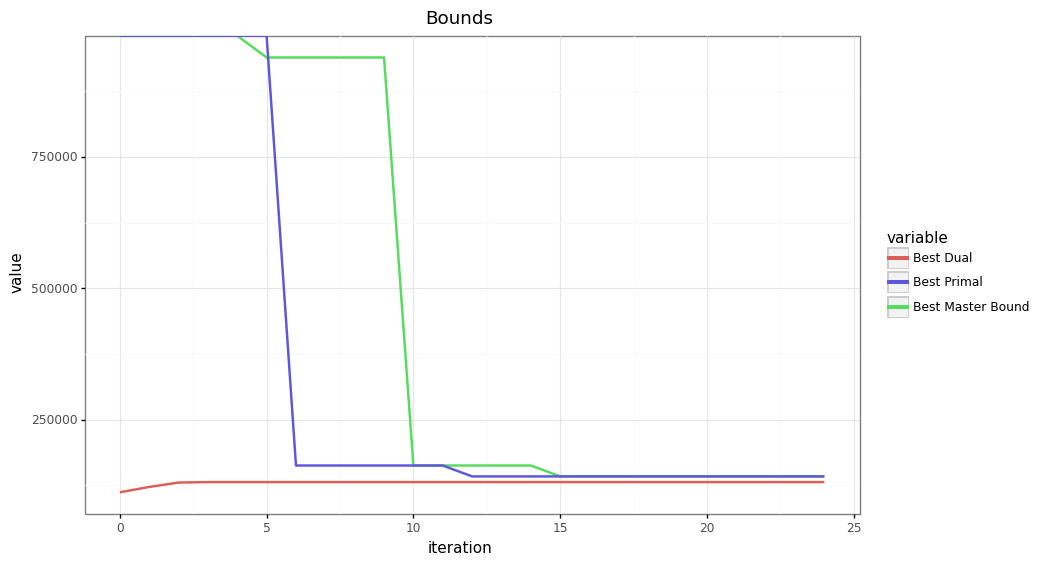

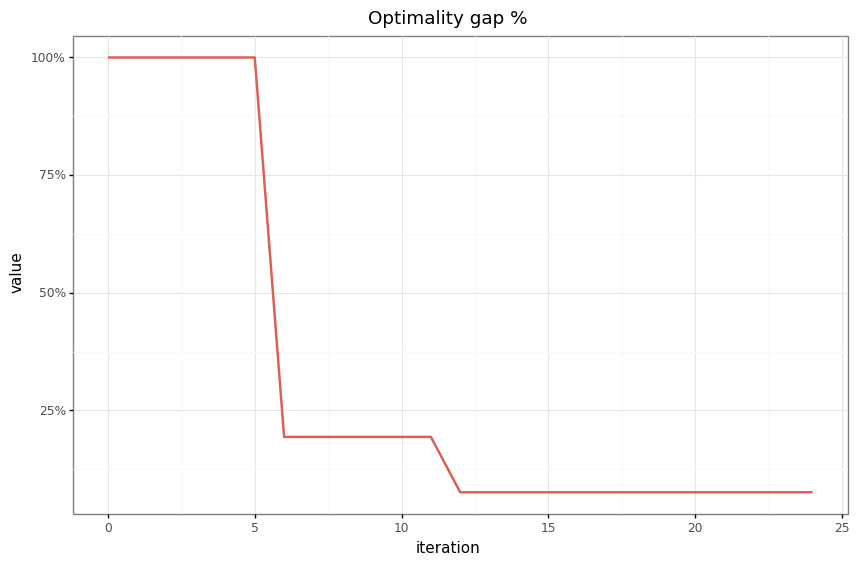

In [16]:
kpis = extract_kpis(kpi_collector.table())
print(algo_charts.bounds(kpis))
print(algo_charts.gap(kpis))

In [17]:
solution = bounds_tracker.best_primal_solution.solution

In [18]:
feasible, analysis = ck.check_solution(data, solution)
assert feasible, "ERROR: final solution is infeasible."

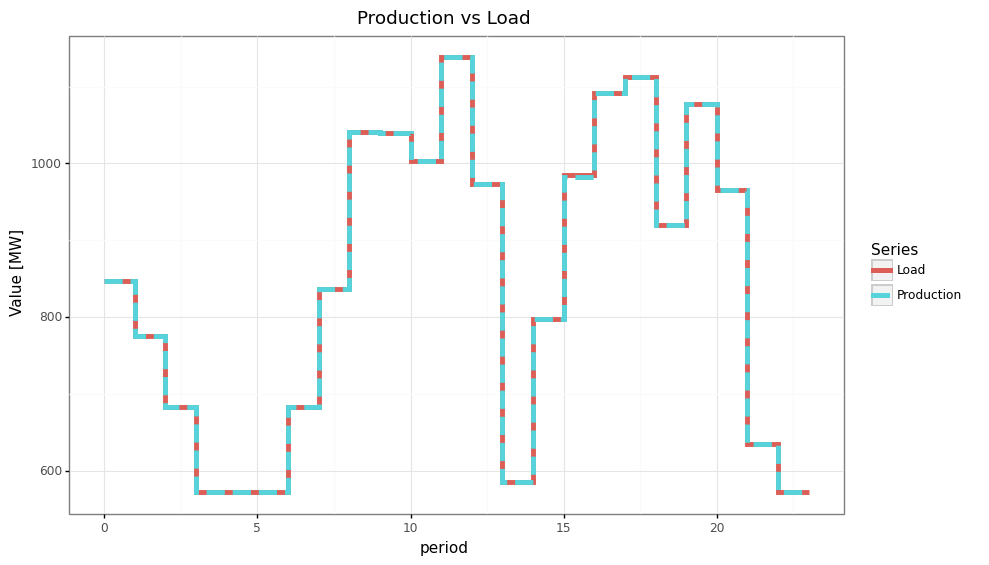

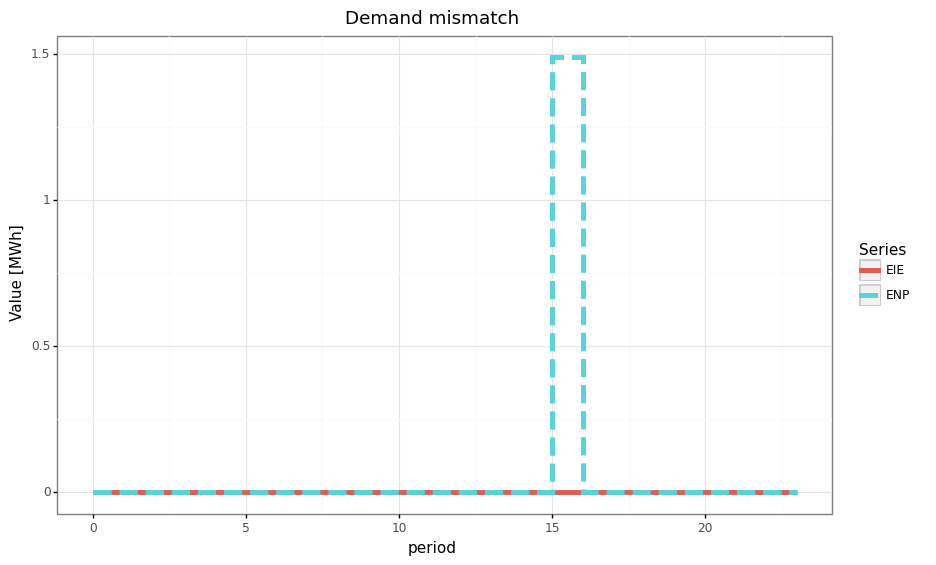

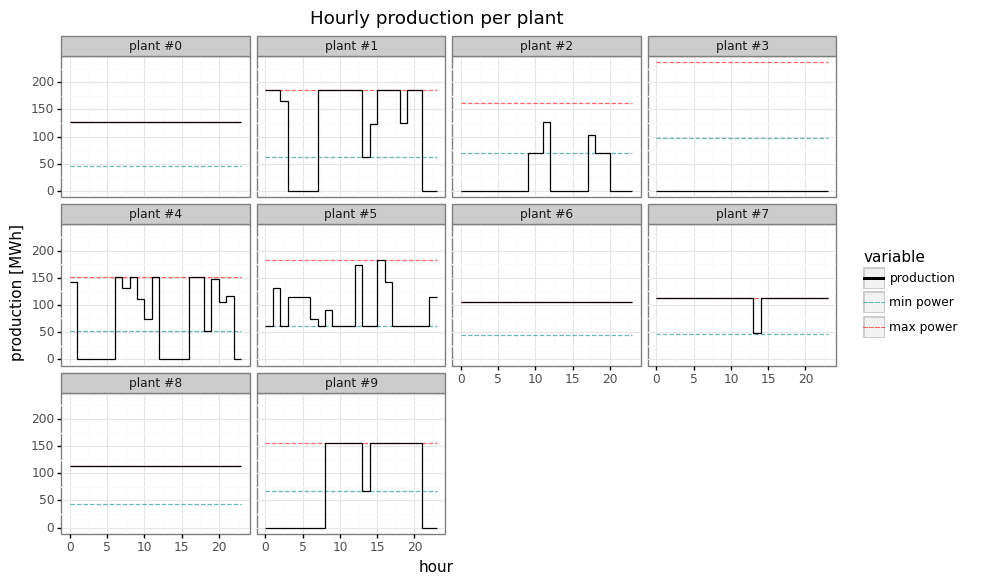

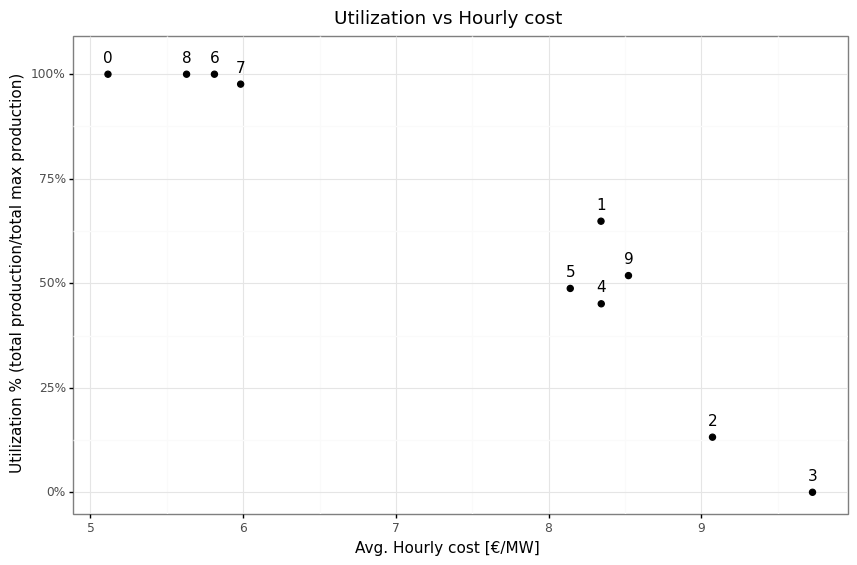

In [19]:
plots = [
    charts.total_production(data, solution),
    charts.enp_vs_eie(data, solution),
    charts.production_by_plant(data, solution),
    charts.plant_utilization(data, solution),
]

for p in plots:
    print(p)